In [2]:
#packages import
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

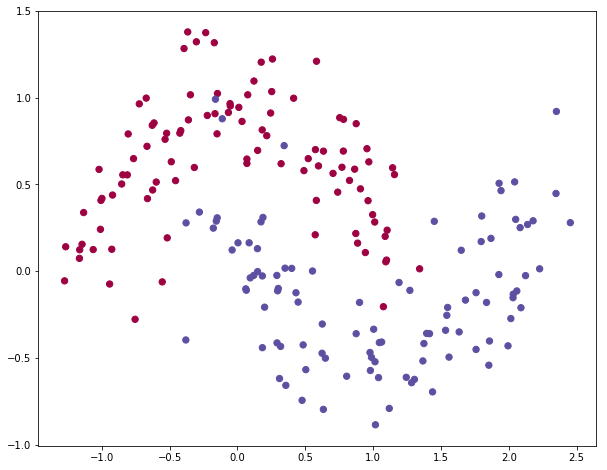

In [4]:
np.random.seed(2)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)

The dataset we generated has two classes, plotted as red and blue points. We can think of the blue dots as male patients and the red dots as female patients, with the x- and y- axis being medical measurements.

Our goal is to train a Machine Learning classifier that predicts the correct class (male or female) given the x- and y- coordinates. Note that the data is not linearly separable, we can't draw a straight line that separates the two classes. This means that linear classifiers, such as Logistic Regression, won't be able to fit the data unless you hand-engineer non-linear features (such as polynomials) that work well for the given dataset.

<h2>Logistic Regression</h2>

To demonstrate the point let's train a Logistic Regression classifier. It's input will be the x- and y-values and the output the predicted class (0 or 1). 

In [5]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [9]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
     # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    

Text(0.5,1,'Logistic Regression')

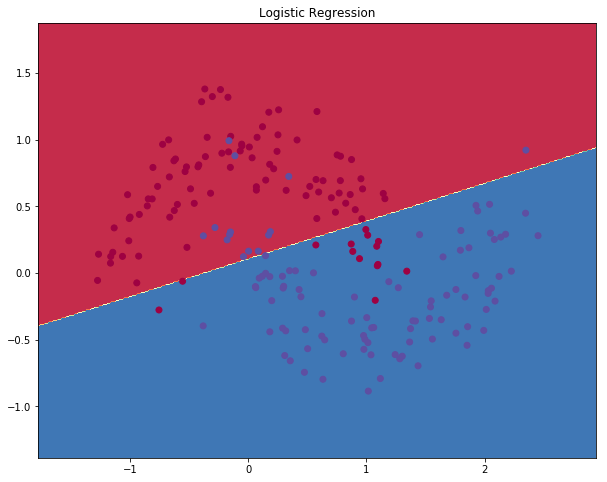

In [10]:
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

The graph shows the decision boundary learned by our Logistic Regression classifier. It separates the data as good as it can using a straight line, but it's unable to capture the "moon shape" of our data.

<h2>Implementation using Neural Network</h2>

In [11]:
num_examples = len(X) #training set size
nn_input_data = 2 # input layer dimensionality
nn_output_data = 2 # output layer dimensionality

# Gradient descent parameters (picked randomly)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

First let's implement the loss function

In [55]:
def loss_function(model):
    W1,b1,W2,b2 = model['W1'],model['b1'],model['W2'],model['b2']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X, W1) + b1
    a1 = np.tanh(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = np.tanh(z2)
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    #Calulate the loss
    correct_probs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(correct_probs)
    #Add regualrization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [56]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    #Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis= 1, keepdims=True)
    return np.argmax(probs, axis=1)

The function to train our Neural Network. It implements batch gradient descent using the backpropagation derivates we found above.

In [57]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_interations: Number of interations through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_iterations=20000, print_loss=False):
    #Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_data, nn_hdim) / np.sqrt(nn_input_data)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_data) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_data))
    
    model = {}
    
    #gradient descent. For each batch....
    for i in range(0, num_iterations):
        
        #Forward propagation
        z1 = np.dot(X, W1) + b1
        a1 = np.tanh(z1)
        z2 = np.dot(a1, W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        #Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = np.dot(a1.T, delta3)
        db2 = np.sum(delta3, axis=0, keepdims= True)
        delta2 = np.dot(delta3, W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        
        #Gradiesnt descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        #Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, loss_function(model)))
    
    return model
        

Loss after iteration 0: 0.438709
Loss after iteration 1000: 0.095423
Loss after iteration 2000: 0.092568
Loss after iteration 3000: 0.091689
Loss after iteration 4000: 0.091458
Loss after iteration 5000: 0.091349
Loss after iteration 6000: 0.091286
Loss after iteration 7000: 0.091248
Loss after iteration 8000: 0.091223
Loss after iteration 9000: 0.091206
Loss after iteration 10000: 0.091194
Loss after iteration 11000: 0.091186
Loss after iteration 12000: 0.091180
Loss after iteration 13000: 0.091176
Loss after iteration 14000: 0.091173
Loss after iteration 15000: 0.091171
Loss after iteration 16000: 0.091169
Loss after iteration 17000: 0.091168
Loss after iteration 18000: 0.091167
Loss after iteration 19000: 0.091167


Text(0.5,1,'Decision Boundary for hidden layer size 3')

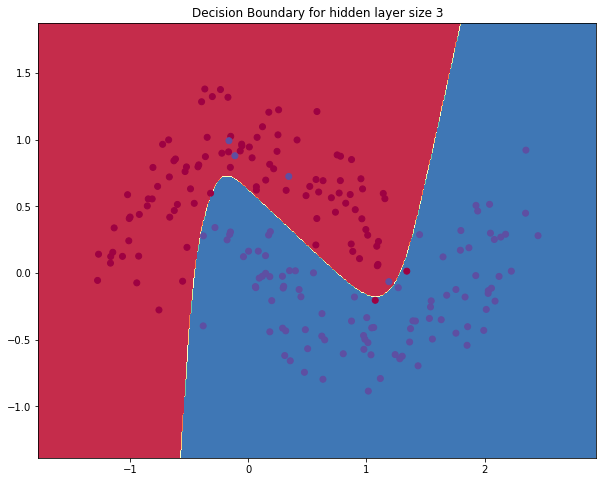

In [58]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

Yay! This looks pretty good. Our neural networks was able to find a decision boundary that successfully separates the classes.

<h2>Varying the hidden layer size</h2>

In the example above we picked a hidden layer size of 3. Let's now get a sense of how varying the hidden layer size affects the result.

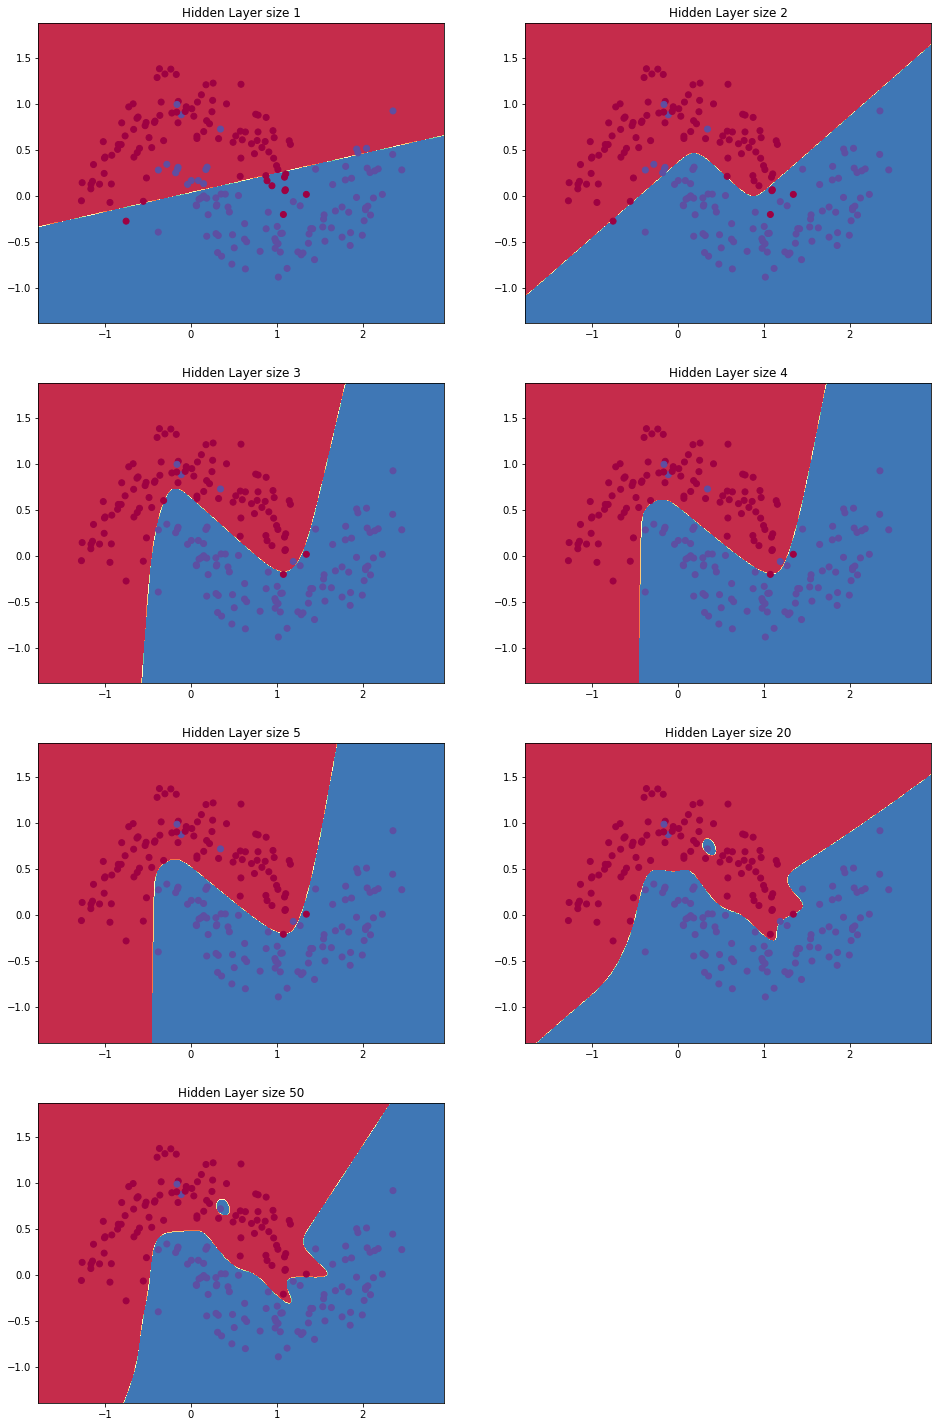

In [59]:
plt.figure(figsize=(16,32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()